# Data
7개의 데이터가 있습니다:

* **application_train/application_test**: 각 대출 신청 정보가 담겨 있는 메인 train, test 데이터. 모든 대출건은 각각 자기의 행을 가지고 있고 SK_ID_CURR feature에 의해 식별됩니다. TARGET 값의 0은 상환되었다는 의미이고, 1은 아직 상환되지 않았다는 의미입니다.
* **bureau**: 다른 금융 기관에서의 고객들의 이전 신용에 관한 데이터. 각 이전 신용은 bureau에서 자기의 행을 가지고 있지만, 신청 데이터에 관한 하나의 대출은 여러개의 이전 신용 정보들을 가지고 있을 수 있습니다.
* **bureau_balance**: bureau에서의 이전 신용 정보에 대한 월간 데이터. 각 행은 이전 신용 정보의 한달치이며, 이전 신용정보는 신용기간이 만료되는 각 월에 대한 여러개의 행을 가질 수 있다.
* **previous_application**: 신청 데이터에서 대출이 있는 고객들의 Home Credit에서의 이전 대출 신청 정보. 신청 데이터에서의 각 현재 대출 정보는 여러개의 이전 대출 정보를 가질 수 있다. 각각의 이전 신청 정보는 한 행을 가지고 SK_ID_PREV feature을 통해 식별된다.
* **POS_CASH_BALANCE**: 고객들이 Home Credit을 통해 가지고 있던 이전 판매 시점 혹은 현금 대출에 대한 월별 데이터. 각 행은 이전 판매 시점 혹은 현금 대출 정보의 한달치이며, 하나의 이전 대출 정보는 여러개의 행을 가질 수 있다.
* **credit_card_balance**: Home Credit을 통해 고객들이 가지고 있는 이전 신용 카드에 대한 월별 데이터. 각 행은 한 달 동안의 신용카드 잔액이며, 각 신용 카드는 여러개의 행을 가질 수 있습니다.
* **installments_payment**: Home Credit에서 이전 대출에 대한 지불 내역. 결제할 때 마다 행이 하나씩 있고, 결제가 누락될 때마다 행이 하나씩 있습니다.


이 다이어그램은 어떻게 모든 데이터가 관련되어 있는지 보여줍니다:
![home_credit](home_credit.png)

게다가, 모든 칼럼들의 정의(in HomeCredit_columns_description.csv), 제출 파일의 예가 제공됩니다.\
이 노트북에서는 한번에 조금씩 문제의 이해를 위해 메인 데이터인 application 데이터만 다룰 것입니다.

## Metric: ROC AUC
ROC(Reciever Operating Characteristic) 곡선은 TPR(True Positive Rate)과 FPR(False Positive Rate)을 그래프로 나타냅니다.\
![Reciever Operating Characteristic](Reciever_Operating_Characteristic.png)\
그래프의 단일 선은 단일 모델에 대한 곡선을 나타내고 선을 따라 이동하면 긍정적인 인스턴스를 분류하는 데 사용되는 임계값 변경을 나타냅니다. 임계값은 오른쪽 상단에서 0에서 시작하여 왼쪽 하단에서 1로 이동합니다. 왼쪽에 있고 다른 곡선 위에 있는 곡선은 더 나은 모델을 나타냅니다. 예를 들어, 파란색 모델은 빨간색 모델보다 낫고, 이는 단순한 무작위 추측 모델을 나타내는 검은색 대각선보다 낫습니다.

AUC(Area Under the Curve)는 이름 자체로 설명이 됩니다. AUC는 단순하게 ROC 곡선 아래의 영역입니다. 이 metric은 0에서 1사이이며 모델 점수가 높을수록 점수가 높습니다. 단순하게 무작위 추측하는 모델의 ROC AUC는 0.5입니다.

ROC AUC에 따라 분류기를 측정할 때 0 또는 1 값을 생성하지 않고, 0과 1 사이의 확률을 생성합니다. 정확도라는 용어를 생각해볼 때, 혼란스러울 수 도 있지만, 불균형 데이터일 경우, 단순 정확도는 최고의 metric이 아닙니다. 예를 들어, 99.9999% 정확도로 테러리스트를 탐지할 수 있는 모델을 만들고 싶다면 모든 사람이 테러리스트가 아니라고 예측하는 모델을 만들기만 하면 됩니다. 이러한 것을 봤을때 단순한 정확도는 효과적이지 않으며(recall이 0이 됨), 분류기의 성능을 보다 정확하게 반영하기 위해서는 ROC AUC 또는 F1 점수와 같은 좀 더 발전된 metric을 사용합니다. 높은 ROC AUC 점수를 가진 모델은 당연히 높은 정확도를 가지지만 ROC AUC가 더 모델 성능을 잘 나타냅니다.

### Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 300)

### Read in Data

In [2]:
print(os.listdir('../[3rd] Home Credit Default Risk/input'))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
# train data
app_train = pd.read_csv('../[3rd] Home Credit Default Risk/input/application_train.csv')
print('Training data shape: {}'.format(app_train.shape))
app_train.head()

Training data shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [4]:
# test data
app_test = pd.read_csv('../[3rd] Home Credit Default Risk/input/application_test.csv')
print('Test data shape : {}'.format(app_test.shape))
app_test.head()

Test data shape : (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

### Exploratory Data Analysis

#### Examin the Distribution of the Target Column

In [5]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

위의 value_counts()를 통해 TARGET 칼럼이 불균형 데이터라는 것을 알 수 있습니다.\
제 시간에 대출을 상환을 한 사람이 그렇지 않은 사람보다 훨씬 많습니다.\
좀 더 정교한 머신러닝 모델에 들어가면, 불균형을 반영하기 위해 데이터 표현에 따라 클래스에 가중치를 부여할 수 있습니다.

#### Examin Missing Values
결측치의 개수와 각 칼럼의 결측치 비율을 봅시다.

In [6]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Missing Vlaues',
                                                              1: "% of Total Values"})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values("% of Total Values", ascending=False).round(1)
    
    print('Your selected dataframe has {} columns.\n'.format(str(df.shape[1])),
          'There are {} columns that have missing values.'.format(str(mis_val_table_ren_columns.shape[0])))
    
    return mis_val_table_ren_columns

In [7]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
 There are 67 columns that have missing values.


,Missing Vlaues,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


머신러닝 모델을 만들 때는 결측치들을 다른 값으로 채워넣어야 합니다.\
하지만 여기선 결측치을 알아서 처리해주는 XGBoost 같은 모델을 사용할 예정입니다.\
다른 방법으로는 결측치 비율이 높은 칼럼들을 삭제해주는 것이지만, 이러한 칼럼들이 현재 머신러닝 모델에 도움이 되는지 안되는지 알 수 없기 때문에 지금은 모든 컬럼을 유지합니다.

#### Colum Types
`object` 는 문자열과 범주형 칼럼을 포함합니다.

In [8]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [9]:
# object 칼럼들의 unique 값 확인
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

대부분의 범주형 변수들은 상대적으로 unique 값이 작습니다.

#### Encoding Categorical Values
LightGBM과 같은 몇몇 모델을 제외하고 머신러닝 모델은 변주형 변수를 제대로 다룰 수 없습니다.\
따라서, 이 feature들을 머신러닝 모델에 넣기 전에 숫자로 인코딩하는 방법을 찾아야 합니다.\
여기에는 이러한 프로세스를 수행하기 위한 주된 2가지 방법이 있습니다.

* Label encoding: 기존의 칼럼에 각각의 값에 해당하는 숫자를 할당한다.\
![LabelEncoding](LabelEncoding.png)

* One Hot Encoding: 값에 해당하는 새로운 칼럼들을 만들어 준다. (카테고리에 해당하는 값은 1, 아니면 0으로)\
![OneHotEncoding](OneHotEncoding.png)

label encoding의 문제는 카테고리에 임의의 순서를 부여한다는 것입니다.\
각 범주에 할당된 값은 무작위이며, 카테고리의 고유의 특성을 반영하지 않습니다.\
위의 예에서 프로그래머는 4, 데이터 과학자는 1이지만 동일한 프로세를 다시 수행하면 레이블이 반대로 되거나 완전히 다를 수 있습니다.\
따라서 모델에 우리가 원하지 않는 잘못된 가중치를 할당할 수 있습니다.
따라서, 범주형 변수(예: 남성/여성)에 대해 unique 값이 두 개인 경우 레이블 인코딩은 괜찮지만, 2개 이상인 경우 one hot encoding이 안전한 방법입니다.

one hot encoding의 유일한 단점은 feature의 수(데이터의 차원)가 폭발적으로 늘어날 수 있다는 것입니다.\
이를 위해 one hot encoding을 수행한 후 PCA 또는 기타 차원 축소 방법을 수행하여 차원 수를 줄일 수 있습니다.

이 노트북에서는 카테고리가 2개만 있는 범주형 변수에 대해 레이블 인코딩을 사용하고, 카테고리가 2개 이상인 범주형 변수에 대해 one hot encoding을 사용합니다.

#### Label Encoding and One-Hot-Encoding

In [10]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [11]:
# One-Hot-Encoding
app_train = pd.get_dummies(app_train) # 값이 숫자형과 문자형이 있으면 문자형만 가변수화
app_test = pd.get_dummies(app_test)

print('Training Features shape : {}'.format(app_train.shape))
print('Test Features shape : {}'.format(app_test.shape))

Training Features shape : (307511, 243)
Test Features shape : (48744, 239)


#### Aligning Training and Testing Data
훈련 데이터와 테스트 데이터 모두에 동일한 feature가 있어야 합니다.\
One Hot Encoding은 테스트 데이터에 표현되지 않은 범주를 가진 일부 범주형 변수가 있기 때문에 훈련 데이터에 더 많은 열을 생성합니다.\
테스트 데이터에 없는 훈련 데이터의 열을 제거하려면 데이터 프레임을 다듬어야 합니다.

먼저 훈련 데이터에서 target 칼럼을 추출합니다.(모델 훈련, 성능 평가에 필요)\
``align``을 수행할 때 행이 아닌 열을 기반으로 해야하기 때문에 ```aixs=1``` 설정

In [12]:
train_lables = app_train['TARGET']

# train과 test 데이터 양쪽에 있는 컬럼만 유지시킨다.
app_train, app_test = app_train.align(app_test, join='inner', axis=1)

# app_train에 다시 TARGET 칼럼 추가
app_train['TARGET'] = train_lables

print('Training Features shape: {}'.format(app_train.shape))
print(f'Testing Features shape: {app_test.shape}')

Training Features shape: (307511, 240)
Testing Features shape: (48744, 239)


이제 훈련 및 테스트 데이터 세트에는 머신러닝에서 요구하는 동일한 feature가 있습니다\
One-Hot-encoding으로 인해 feature의 수가 크게 증가했습니다.\
어느 시점에서 우리는 데이터 세트의 크기를 줄이기 위해 차원 축소(관련 없는 feature 제거)를 시도해야 할 것입니다.

#### Back to Exploratory Data Analysis
##### Anomalies
EDA를 수행할 때 항상 주의를 기울여야 하는 문제는 데이터 내의 비정상적인 값입니다.\
이는 잘못 입력한 숫자, 측정 장비의 오류 또는 값은 유효하지만 극단적인 측정으로 인한 것일 수도 있습니다.

비정상적인 값을 정량적으로 살펴보는 방법 중 하나는 `describe`메서드를 사용하여 칼럼의 통계를 살펴보는 것입니다.

`DAYS_BIRTH` 칼럼들의 값은 현재 대출 신청을 기준으로 기록되기 때문에 음수입니다.\
연도 단위로 보려면 -1으로 곱하고 365로 나눌 수 있습니다.

In [13]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

연도는 비정상적인 값이 없습니다. 근무날짜는 어떨까요?

In [14]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

비정상적인 값이 있어 보입니다. max 값은 약 1000년 정도가 됩니다.

(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.]),
 [Text(0, 0.0, '0'),
  Text(0, 50000.0, '50000'),
  Text(0, 100000.0, '100000'),
  Text(0, 150000.0, '150000'),
  Text(0, 200000.0, '200000'),
  Text(0, 250000.0, '250000'),
  Text(0, 300000.0, '300000')])

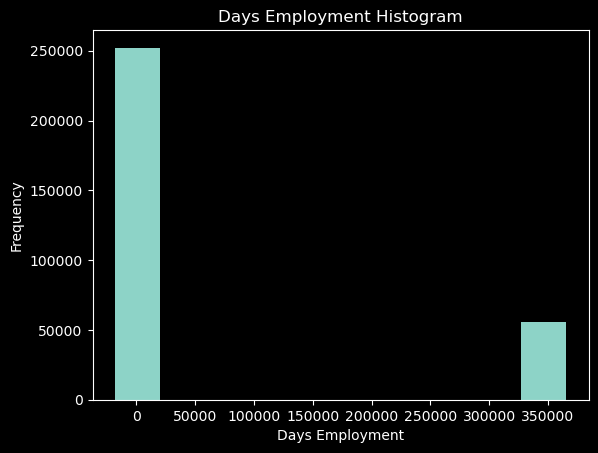

In [15]:
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

비정상적인 값으로 여겨지는 고객들을 하위 집합으로 분류하고 다른 고객들에 비해 채무 불이행 비율이 높거나 낮은 경향이 있는지 살펴봅시다.

In [16]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


비정상적인 값으로 여겨지는 고객들의 채무 불이행 비율이 더 낮은 것으로 나타납니다.

예외 처리는 정해진 규칙 없이 상황에 따라 다릅니다.\
가장 안전한 접근 방식 중 하나는 예외를 결측값으로 설정한 다음 값을 채워 넣는 것입니다.\
이 경우 모든 이상치 값이 정확히 같으므로 이러한 대출이 모두 공통적인 어떤 것을 공유할 것으로 가정해 동일한 값으로 채웁니다.

여기서는 비정상적인 값을 가지는 값을 `np.nan`으로 바꾼 다음, 값의 비정상 여부를 나타내는 새로운 칼럼을 만듭니다.

Text(0.5, 0, 'Days Emplyment')

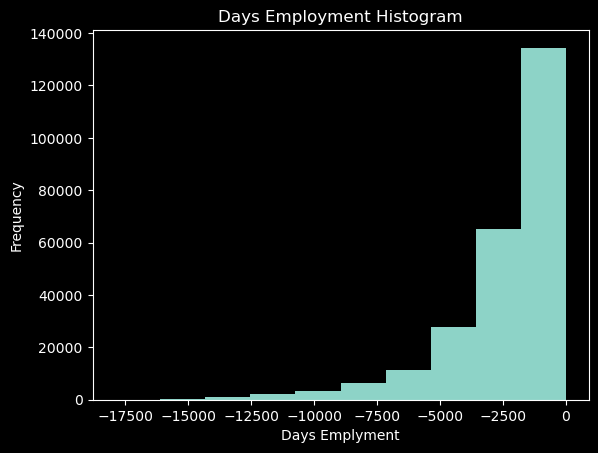

In [17]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Emplyment')

분포는 우리가 예상하는 것과 훨씬 더 비슷한 것으로 보이며, 이러한 값이 원래 비정상임을 모델에 알려주는 새로운 칼럼도 만들었습니다.\
(NaN 값을 아마 칼럼의 median 으로 채워야하기 때문에)

비정상적인 값을 제외한 값들은 이상치가 없어 보입니다.(위에서 본 것 처럼)
test 데이터에도 동일한 작업을 진행해봅시다.

In [18]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED'] == 365243
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

print('There are {} anomalies in the test data out of {} entries.'.format(app_test['DAYS_EMPLOYED_ANOM'].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries.


##### Correlations
Correlation coefficient는 기능의 상관관계를 나타내는 가장 좋은 방법은 아니지만, 데이터 내에서 가능한 관계에 대한 아이디어를 제공합니다.\
상관 계수의 절대값에 대한 몇 가지 일반적인 해석은 다음과 같습니다.

* .00-.19: "very weak"
* .20-.39: "weak"
* .40-.59: "moderate"
* .60-.79: "strong"
* .80-1.0: "very strong"

In [19]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Nagative Correlations: \n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Nagati

더 중요한 상관 관계를 살펴보겠습니다. `DAYS_BIRTH`는 가장 강한 양의 상관관계입니다.\
설명을 보면 `DAY_BIRTH`는 대출 당시 고객의 나이로 음수입니다.\
상관 관계는 양수이지만 이 feature는 실제로는 음수입니다.\
즉, 클라이언트가 나이가 들수록 대출 불이행 가능성이 낮아집니다.(즉, target==0)\
약간 혼란스럽기 때문에 feature에 절대값을 취하면 상관 관계가 음수가 됩니다.

##### Effect of Age on Repayment

In [20]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

고객이 나이가 들어감에 따라 `TARGET`과 음의 선형 관계가 있으며, 이는 고객이 나이가 들수록 대출을 더 자주 제때 상환하는 경향이 있음을 의미합니다.\
먼저 이 값을 더 자세히 살펴보기 위해 나이 히스토그램을 만듭니다.\
그래프를 좀 더 이해하기 쉽게 만들기 위해 x축을 연 단위로 지정합니다.

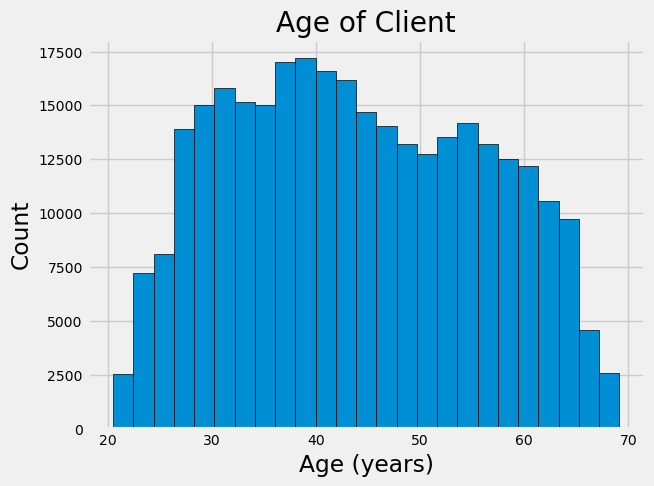

In [21]:
plt.style.use('fivethirtyeight')

plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
plt.title('Age of Client', c='black')
plt.xlabel('Age (years)', c='black')
plt.ylabel('Count', c='black')
plt.xticks(c='black', fontsize=10)
plt.yticks(c='black', fontsize=10)
plt.show()


연령 분포는 모든 연령이 이상치가 없다는 것 외에는 많은 것을 말해주지 않습니다.\
target에 대한 연령의 영향을 시각화하기 위해 kernel density estimate plot(KDE)을 만듭니다.\
KDE plot은 단일 변수의 분포를 보여주며 좀 더 스무스한 히스토그램으로 생각할 수 있습니다.\
`kdeplot`을 사용해 봅시다.

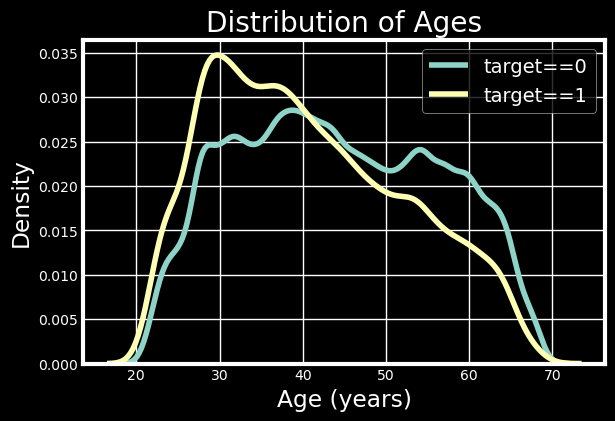

In [22]:
plt.style.use('dark_background')
plt.figure(figsize=(6, 4))

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label='target==0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label='target==1')
plt.legend()
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');
plt.xticks(fontsize=10); plt.yticks(fontsize=10);
plt.show()

target == 1 곡선은 나이가 어린쪽으로 기울어져 있습니다.\
`DAYS_BIRTH`와 `TARGET`이 유의미한 상관관계는 아니지만(상관계수: -0.07), 이 변수는 `TARGET`에 영향을 미치기 때문에 머신러닝 모델에서 유용할 것 같습니다.\
이제 다른 방식으로 살펴보겠습니다.(연령대별 평균적인 대출 상환 실패 정도)

그래프를 만들기 위해 먼저 연령 카테고리를 각각 5년 단위로 자릅니다.\
그런 다음 각 카테고리에 대해 target의 평균 값을 계산하여 각 연령 카테고리에서 상환되지 않은 대출 비율을 알려줍니다.

In [23]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# (min, max) == (20.517808219178082, 69.12054794520547)
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'],
                                 bins=np.linspace(20, 70, num=11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [24]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


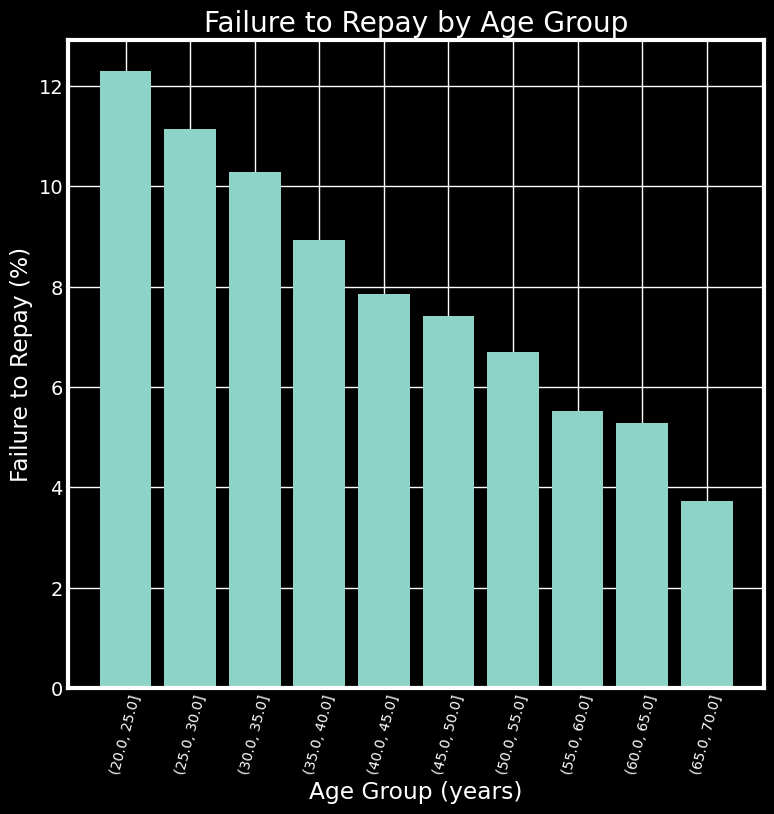

In [25]:
plt.figure(figsize=(8, 8))
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation=75, fontsize=10); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

위의 그래프에서 분명한 추세가 보입니다.\
젋은 대출 신청자는 대출을 상환하지 않을 가능성이 더 높습니다.\
가장 젊은 3개의 그룹은 연체율이 10% 이상, 가장 나이가 많은 그룹은 연체율이 5% 미만입니다.\
이 정보는 은행에서 직접 사용할 수 있는 정보입니다.\
젊은 고객은 대출금을 상환할 가능성이 적기 때문에 더 많은 가이드나 재무 관리 팁을 제공받아야 합니다.\
그렇다고 해서 은행이 어린 고객들을 차별해야 한다는 의미는 아닙니다.\
하지만, 젊은 고객들이 제때 대출을 상환할 수 있도록 예방 조치를 취하는 것이 현명할 것입니다.

##### Exterior Sources
target과 가장 강한 음의 상관 관계를 가진 3개의 변수는 `EXT_SOURCE_1`, `EXT_SOURCE_2` 및 `EXT_SOURCE_3`입니다.\
설명에 따르면 위의 feature들은 외부 데이터 소스로부터 만들어진 정규화된 점수를 나타냅니다.\
정확히 이것이 무엇을 의미하는지 모르겠지만 수많은 데이터 소스를 사용하여 만든 일종의 누적 신용 등급일 수 있습니다.

이제 이 변수들을 살펴보겠습니다.
먼저 target과 `EXT_SOURCE` feature간의 상관 관계를 나타낼 수 있습니다.

In [26]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


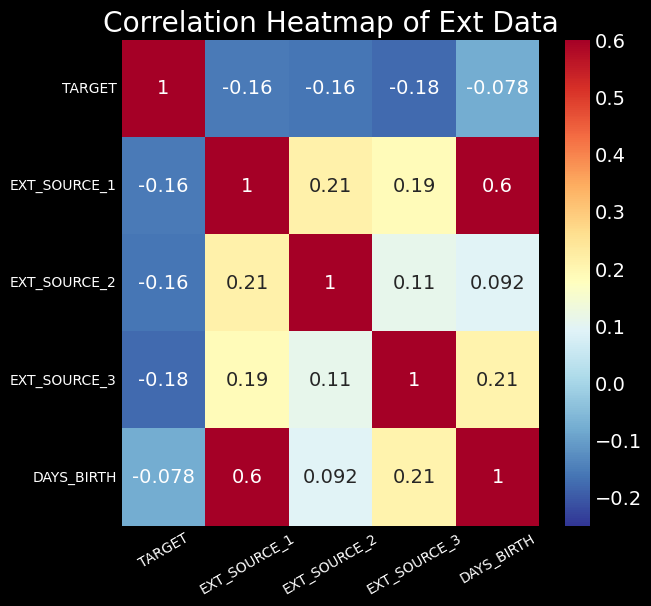

In [27]:
plt.figure(figsize=(6, 6))
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Correlation Heatmap of Ext Data')
plt.show()

세 가지 `EXT_SOURCE` feature들은 모두 target과 음의 상관 관계를 가지며, 이는 `EXT_SOURCE`의 값이 증가함에 따라 클라이언트가 대출을 상환할 가능성이 더 높음을 나타냅니다.\
또한 `DAYS_BIRTH`가 `EXT_SOURCE_1`과 양의 상관 관계가 있음을 알 수 있습니다.\
이는 이 점수의 요인 중 하나가 고객 연령이 수 있음을 나타냅니다.

다음으로 target 값 별로 각 feature의 분포를 시각화 할 수 있습니다.\
이를 통해 이 변수들이 target에 미치는 영향을 알 수 있습니다.

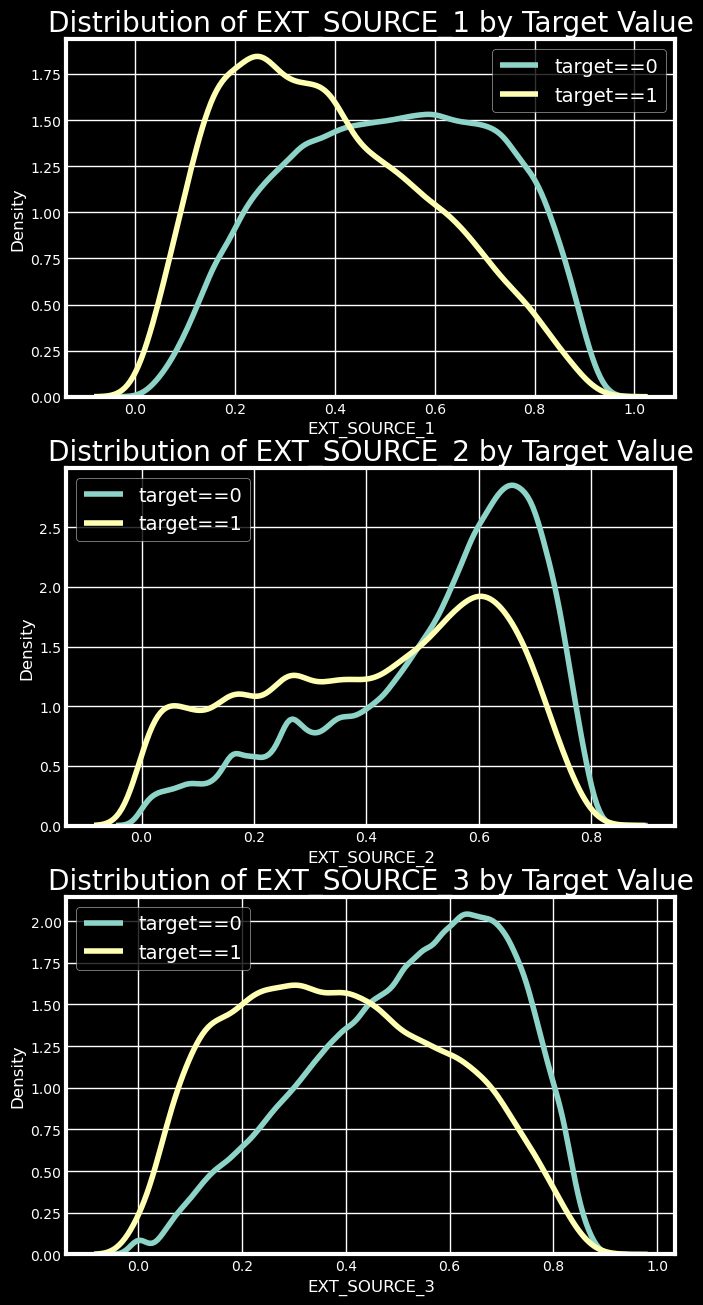

<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize=(7, 15))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label='target==0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label='target==1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend()

plt.show()
plt.tight_layout(h_pad=2.5)

`EXT_SOURCE_3`은 target 값 간의 가장 큰 차이를 나타냅니다.\
이를 통해 이 feature는 대출 신청자가 대출을 상환할 가능성과 어느 정도의 관계가 있음을 알 수 있습니다.\
이 관계들은 사실 그다지 강력하지 않습니다.(매우 약한 상관관계)\
하지만, 이러한 변수는 머신러닝 모델이 대출을 제때 상환할지 여부를 예측하는데 여전히 유용합니다.


##### Pairs Plot
최종 탐색 그래프로 `EXT_SOURCE` 변수들과 `DAYS_BIRTH` 변수의 pairplot을 만들 수 있습니다.\
PairPlot은 단일 변수의 분포뿐만 아니라 여러 변수 간의 상관관계를 볼 수 있게 해주기 때문에 훌륭한 탐색 툴입니다.

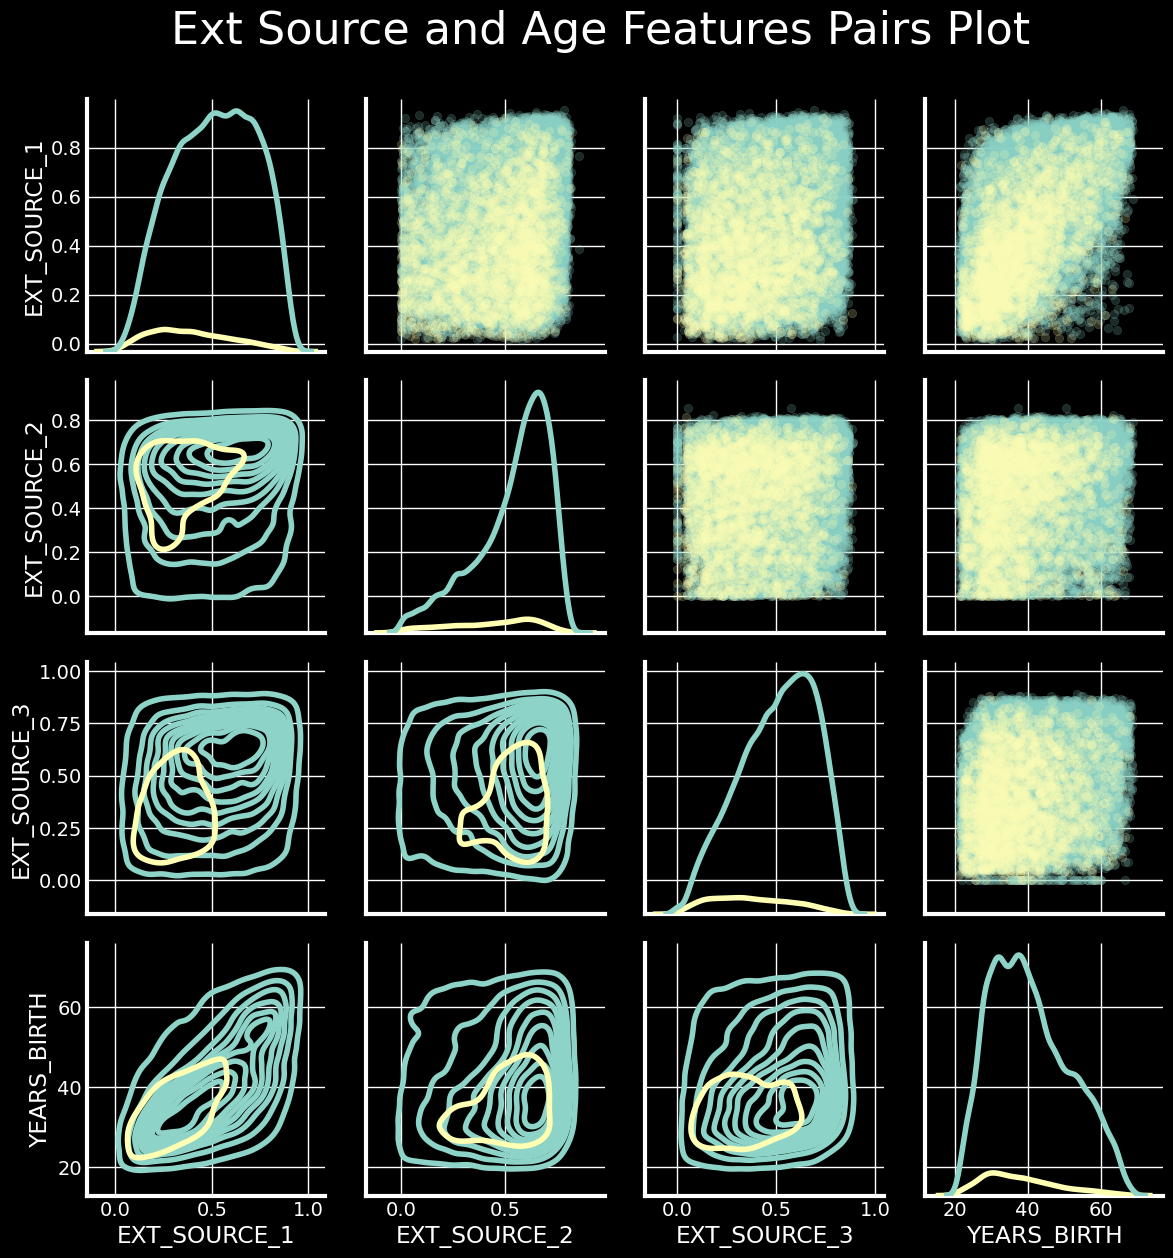

In [29]:
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

plot_data = plot_data.dropna().loc[:100000, :]

grid = sns.PairGrid(data=plot_data, height=3, diag_sharey=False,
                    hue='TARGET',
                    vars=[x for x in list(plot_data.columns) if x != 'TARGET'])

# 대각선 위의 그래프로는 scatterplot
grid.map_upper(plt.scatter, alpha=0.2)

# 대각선은 kdeplot
grid.map_diag(sns.kdeplot)

# 대각선 아래는 density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)
plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)
plt.show()

여기에서 노란색은 대출이 상환되지 않은 경우를 나타내고, 녹색은 대출이 상환된 경우를 나타냅니다.\
여기서는 데이터 내에서 다양한 관계를 볼 수 있습니다.\
`EXT_SOURCE_1`과 'DAYS_BIRTH' 사이에 적당한 양의 선형 관계가 있는 것으로 보이며, 이는 이 feature가 고객들의 연령을 고려해야 할 수 있음을 나타냅니다.

#### Feature Engineering
Kaggle 대회는 feature engineering에 의해 우승여부가 결정됩니다.\
이러한 대회들은 데이터에서 가장 유용한 feature를 생성할 수 있는 사람이 승리합니다.\
(구조화된 데이터의 경우 모든 우승 모델이 그래디언트 부스팅의 변형인 경향이 있기 때문에 대부분 맞는 말입니다.)

그리고 이러한 것들은 머신러닝의 패턴 중 하나를 나타냅니다.\
: featuer engineering이 모델 구축 및 hyperparameter 조정보다 좋은 결과를 가져오는 것.

올바른 모델과 최적의 하이퍼파라미터 설정을 선택하는 것이 중요하지만 모델은 제공된 데이터에서만 학습할 수 있습니다.

feature engineering은 일반적인 프로세스를 말하며 feature 구성(기존 데이터에서 새로운 feature 추가)과 feature 선택(가장 중요한 feature만 선택하거나 다른 차원 축소 방법 사용 등)을 모두 포함할 수 있습니다.

다른 데이터 소스를 사용할 때 많은 feature engineering을 수행하지만 이 노트북에서는 두 가지 간단한 feature 구성 방법만 시도합니다.

* Polynomial Features
* Domain knowledge features

##### Polynomial Features
간단한 feature 구성 방법 중 하나는 polynomial features가 있습니다.\
이 방법에서는 기존 feature의 제곱과 기존 feature 간의 상호 작용을 하는 feature을 만듭니다.\
예를 들어, `EXT_SOURCE_1^2` 및 `EXT_SOURCE_2^2`변수와 `EXT_SOURCE_1 x EXT_SOURCE_2`, `EXT_SOURCE_1 x EXT_SOURCE_2^2`, `EXT_SOURCE_1^2 x EXT_SOURCE_2^2`등과 같은 변수를 생성할 수 있습니다.

여러 개별 변수의 조합인 이러한 feature들은 변수 간의 상호 작용을 담기 때문에 **interaction terms**라고 부릅니다.\
즉, 두 개의 변수가 그 자체로는 target에 큰 영향을 미치지 않을 수 있지만, 이들을 하나의 interaction variable로 결합하면 target과의 관계를 나타낼 수 있습니다.\
<span style="color:#00FFFF">interaction terms은 여러 변수들의 효과를 담기 위해 통계 모델에서 일반적으로 사용되지만</span>, 머신러닝에서는 자주 사용되지 않습니다.\
그럼에도 불구하고, 여기서는 고객들의 대출 상환 여부를 예측하는데 모델이 도움이 될 수 있는지 알아보기 위해 몇 가지 시도를 해 봅니다.

다음 코드에서는 `EXT_SOURCE` 변수와 `DAYS_BIRTH` 변수를 사용하여 polynomial feature를 생성합니다.\
Scikit-Learn에는 지정된 degree까지 다항식과 interation terms을 생성하는 PolynomialFeatures라는 유용한 클래스가 있습니다.\
여기서는 `degree=3`을 사용합니다.\
(polynomial feature을 생성할 때 feature의 수가 degree에 따라 기하급수적으로 확장되고, overfitting 문제가 발생할 수 있기 때문에 너무 높은 degree를 사용하는 것을 피합니다.)

In [30]:
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median') # 결측치를 중간값으로 대체

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

In [31]:
# 결측치 imputing
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

In [32]:
poly_features.shape, poly_features_test.shape


((307511, 4), (48744, 4))

### Polynomial Features 사용 시 주의 사항:
feature에 결측치를 반드시 제거 또는 대체 해줘야 실행 됨.

In [33]:
from sklearn.preprocessing import PolynomialFeatures
poly_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
poly_transformer = PolynomialFeatures(degree=3)

poly_transformer.fit(poly_features)
print(poly_transformer.get_feature_names_out())

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)
print(type(poly_features))

['1' 'x0' 'x1' 'x2' 'x3' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x1^2' 'x1 x2'
 'x1 x3' 'x2^2' 'x2 x3' 'x3^2' 'x0^3' 'x0^2 x1' 'x0^2 x2' 'x0^2 x3'
 'x0 x1^2' 'x0 x1 x2' 'x0 x1 x3' 'x0 x2^2' 'x0 x2 x3' 'x0 x3^2' 'x1^3'
 'x1^2 x2' 'x1^2 x3' 'x1 x2^2' 'x1 x2 x3' 'x1 x3^2' 'x2^3' 'x2^2 x3'
 'x2 x3^2' 'x3^3']
Polynomial Features shape:  (307511, 35)
<class 'numpy.ndarray'>


In [34]:
poly_transformer.get_feature_names_out(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2', 'EXT_SOURCE_1^3',
       'EXT_SOURCE_1^2 EXT_SOURCE_2', 'EXT_SOURCE_1^2 EXT_SOURCE_3',
       'EXT_SOURCE_1^2 DAYS_BIRTH', 'EXT_SOURCE_1 EXT_SOURCE_2^2',
       'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
       'EXT_SOURCE_1 EXT_SOURCE_3^2',
       'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
       'EXT_SOURCE_1 DAYS_BIRTH^2', 'EXT_SOURCE_2^3',
       'EXT_SOURCE_2^2 EXT_SOURCE_3', 'EXT_SOURCE_2^2 DAYS_BIRTH',
       'EXT_SOURCE_2 EXT_SOURCE_3^2',
       'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
       'EXT_SOURCE_2 DAYS_BIRTH^2', 'EXT_SOURCE_3^3',
       'EXT_SOURCE_3^2 DAYS_BIRTH', 'EXT_SOURCE_3 DAYS_BIR

In [35]:
poly_features = pd.DataFrame(poly_features, 
                             columns=poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                         'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_features["TARGET"] = poly_target

poly_corrs = poly_features.corr()["TARGET"].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [36]:
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=3)

# poly_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']

# interactions_pf = pd.DataFrame(data=poly.fit_transform(poly_features), columns=poly.get_feature_names_out(poly_cols))
# interactions_pf.drop(poly_cols, axis=1, inplace=True)
# print(interactions_pf.shape, interactions_pf.columns)

# poly_features = pd.DataFrame(data=poly_features, columns=poly_cols)
# poly_features = pd.concat([poly_features, interactions_pf], axis=1)

# poly_features['TARGET'] = poly_target
# poly_corrs = poly_features.corr()['TARGET'].sort_values()

# print(poly_features.head(5))
# print('Polynomial Features shape: ', poly_features.shape)
# print(poly_corrs.head(5))

In [37]:
poly_features_test = pd.DataFrame(poly_features_test,
                                  columns=poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

# train과 test 데이터 양쪽에 있는 컬럼만 유지시킨다.
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join='inner', axis=1)

print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape: ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:  (48744, 275)


#### Domain Knowledgy Features
신용 전문가가 아니기 때문에 '도메인 지식'이라고 부르는 것이 옳지 않을 수도 있지만, 이것을 '제한된 금융지식을 적용하려는 시도'라고 부를 수 있습니다.\
따라서, 고객이 채무불이행 여부를 알려주는 데 중요하다고 생각하는 것을 담아내는 몇 가지 feature를 만들 수 있습니다.
* `CREDIT_INCOME_PRECENT`: 고객의 수입에 대한 신용 금액의 백분율
* `ANNUITY_INCOME_PERCENT`: 고객의 소득에 대한 연금 대출의 비율
* `CREDIT_TERM`: 지불 기간(월 단위로 지불해야 하는 기간)(연금은 매월 지불해야 하는 금액이므로)
* `DAYS_EMPLOYED_PERCENT`: 고객의 나이에 대한 고용 일수의 백분율

In [38]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [39]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

##### Visualize New Variables
이러한 도메인 지식 변수들을 그래프에서 시각적으로 탐구해봅시다.\
TARGET 값에 따라 색깔을 다르게 한 kdeplot을 만들 것입니다.

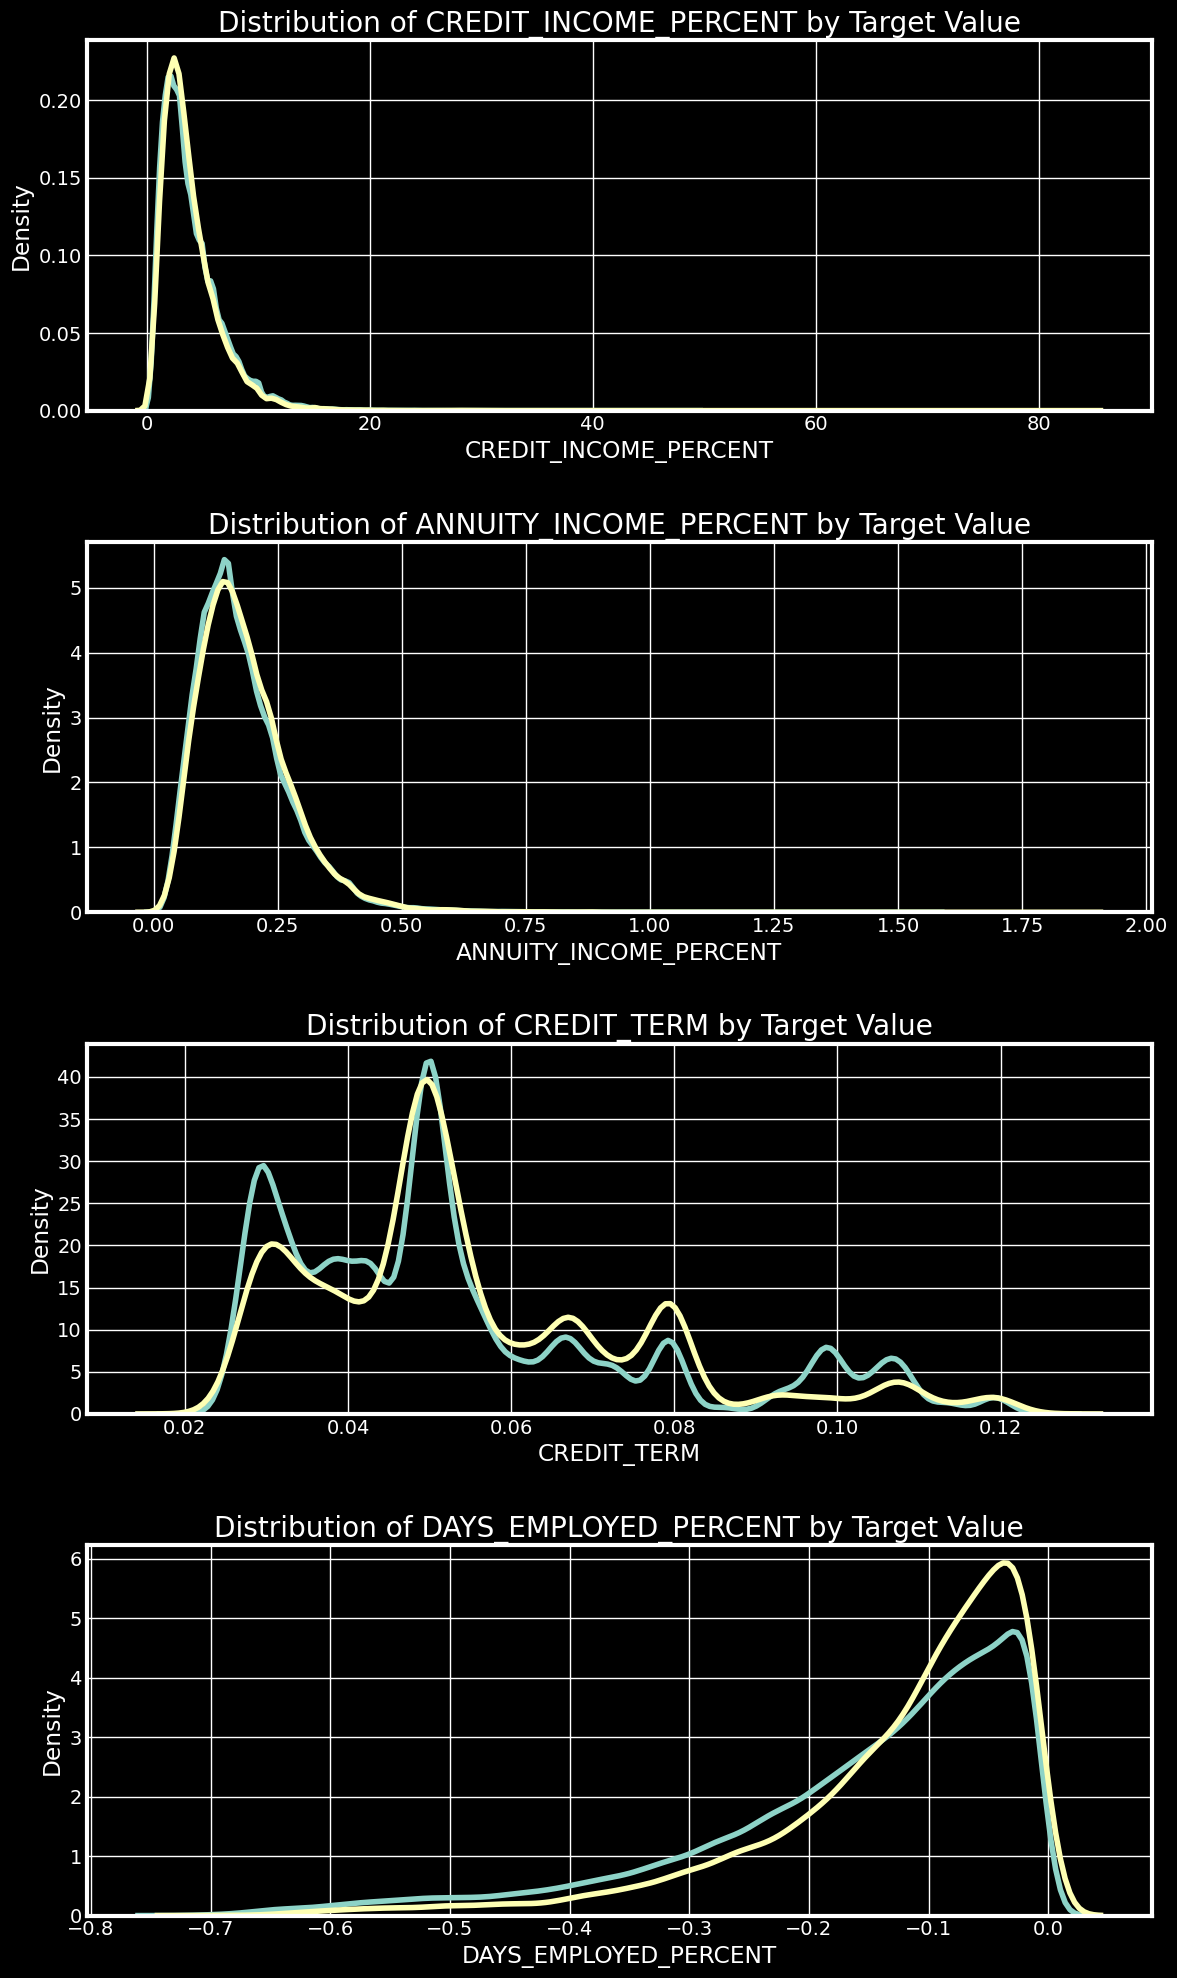

In [40]:
plt.figure(figsize=(12, 20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label='target==0')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label='target==1')
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Density')
    
plt.tight_layout(h_pad=2.5)
plt.show()

위 그래프들을 보면 새로 만든 feature들이 유용한지 불확실합니다.\
그냥 이 feature들을 가지고 모델의 성능을 확인해 봅시다.

#### Baseline
##### Logistic Regression Implementaion

In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET'])
else:
    train = app_train.copy()
    
features = list(train.columns)

test = app_test.copy()

# 결측치에 중간값 채워넣기
imputer = SimpleImputer(strategy='median')

# 0과 1 사이의 값으로 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))

imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(app_test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


In [42]:
train.min(), train.max(), test.min(), test.max()

(0.0, 1.0, -1.8423900789177, 1.0526315789473684)

In [43]:
if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET'])
else:
    train = app_train.copy()
    
features = list(train.columns)

test = app_test.copy()

# 결측치에 중간값 채워넣기
imputer = SimpleImputer(strategy='median')

imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(app_test)

In [44]:
# 0과 1 사이의 값으로 스케일링
train_min = train.min()
train_max = train.max()

train_s = (train - train_min) / (train_max + train_min)
test_s = (test - train_min) / (train_max + train_min)

In [45]:
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


In [46]:
train_s.min(), train_s.max(), test_s.min(), test_s.max()

(0.0, 1.0004218325423289, -4.471028283844607e-06, 0.0379111738844622)

우리는 첫 번째 모델에 대해 Scikit-Learn의 LogisticRegression을 사용할 것입니다.\
기본 모델에서 유일하게 변경할 하이퍼파라미터는 overfitting의 양을 제어하는 정규화 매개변수 C를 낮추는 것입니다.(낮은 값은 과적합을 줄임)\
이렇게 하면 기본 LogisticRegression 보다 조금 더 나은 결과를 얻을 수 있습니다.

In [47]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train, train_lables)

LogisticRegression(C=0.0001)

In [48]:
log_reg.fit(train_s, train_lables)

LogisticRegression(C=0.0001)

이제 모델이 학습되었으므로 예측을 수행하는데 사용할 수 있습니다.\
대출을 갚지 않을 확률을 예측하기를 원하므로, predict.proba 메소드를 사용합니다.\
여기서는 m이 관측값의 수인 m x 2 배열을 반환합니다.\
첫 번째 열은 대상이 0일 확률이고, 두 번째 열은 대상이 1일 확률입니다.\
(단일 행의 경우 두 열의 합이 1이어야 함.)\
대출이 상환되지 않을 확률을 원하므로 두 번째 열을 선택합니다.

In [49]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [50]:
log_reg_pred_s = log_reg.predict_proba(test_s)[:, 1]

In [51]:
submit = app_test[['SK_ID_CURR']]
submit_s = app_test[['SK_ID_CURR']]

submit['TARGET'] = log_reg_pred
submit_s['TARGET'] = log_reg_pred_s

submit.head()
submit_s.head()

,SK_ID_CURR,TARGET
0,100001,0.080729
1,100005,0.080729
2,100013,0.080729
3,100028,0.080728
4,100038,0.080729


In [52]:
submit.to_csv('log_reg_baseline.csv', index=False)
submit_s.to_csv('log_reg_baseline_s.csv', index=False)

**점수는: MinMaxScaler - 0.50311, Maual Scaler - 0.51337**

##### Imporved Model: Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100,
                                       random_state=50,
                                       verbose=1,
                                       n_jobs=-1)

In [54]:
random_forest.fit(train, train_lables)

feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features,
                                    'importance': feature_importance_values})

predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.2s finished


In [55]:
random_forest.fit(train_s, train_lables)

feature_importance_values = random_forest.feature_importances_
feature_importances_s = pd.DataFrame({'feature': features,
                                    'importance': feature_importance_values})

predictions_s = random_forest.predict_proba(test_s)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [56]:
submit = app_test[['SK_ID_CURR']]
submit_s = app_test[['SK_ID_CURR']]

submit['TARGET'] = predictions
submit_s['TARGET'] = predictions_s

submit.to_csv('random_forest_baseline.csv', index=False)
submit_s.to_csv('random_forest_baseline_s.csv', index=False)

**점수는: MinMaxScaler - 0.6759, Maual Scaler - 0.54348**

##### Make Predictions using Engineered Features
Polynomial Features 및 도메인 지식이 모델을 개선했는지 확인하는 유일한 방법은 이러한 feature에 대한 테스트 모델을 훈련시키는 것입니다.\
그런 다음 이러한 feature가 없는 모델의 performance와 비교하여 feature engineering의 효과를 측정합니다.

In [57]:
poly_features_names = list(app_train_poly.columns)

imputer = SimpleImputer(strategy='median')
poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

In [58]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(poly_features)
poly_features_s = scaler.transform(poly_features)
poly_features_test_s = scaler.transform(poly_features_test)

In [59]:
poly_features_s.min(), poly_features_s.max(), poly_features_test_s.max(), poly_features_test_s.min()

(0.0, 1.0000000000000002, 1.0526315789473684, -1.8423900789177)

In [60]:
poly_features_min = poly_features.min()
poly_features_max = poly_features.max()

poly_features_ms = (poly_features - poly_features_min) / (poly_features_max + poly_features_min)
poly_features_test_ms = (poly_features_test - poly_features_min) / (poly_features_max + poly_features_min)

In [61]:
poly_features_ms.min(), poly_features_ms.max(), poly_features_test_ms.min(), poly_features_test_ms.max()

(0.0, 1.0000000030727996, -0.995962479644539, 3.9531700368101904e-05)

In [62]:
random_forest_poly = RandomForestClassifier(n_estimators=100,
                                            random_state=50,
                                            verbose=1,
                                            n_jobs=-1)

In [63]:
random_forest_poly.fit(poly_features_s, train_lables)

predictions = random_forest_poly.predict_proba(poly_features_test_s)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


In [64]:
random_forest_poly.fit(poly_features_ms, train_lables)

predictions_s = random_forest_poly.predict_proba(poly_features_test_ms)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [65]:
submit = app_test[['SK_ID_CURR']]
submit_s = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions
submit_s['TARGET'] = predictions_s

submit.to_csv('random_forest_baseline_engineered.csv', index = False)
submit_s.to_csv('random_forest_baseline_engineered_s.csv', index = False)

**점수는: MinMaxScaler - 0.60467, Maual Scaler - 0.62775**

점수가 같다면 feature engineering한 feature들이 도움이 되지 않습니다.

##### Testing Domain Features

In [66]:
app_train_domain = app_train_domain.drop(columns='TARGET')
domain_feature_names = list(app_train_domain.columns)

imputer = SimpleImputer(strategy='median')
domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

In [67]:
scaler = MinMaxScaler(feature_range=(0, 1))
domain_features_s = scaler.fit_transform(domain_features)
domain_features_test_s = scaler.transform(domain_features_test)

In [68]:
domain_features_s.min(), domain_features_s.max(), domain_features_test_s.min(), domain_features_test_s.max()

(0.0, 1.0000000000000002, -1.8423900789177, 1.9894974270796868)

In [69]:
domain_features_min = domain_features.min()
domain_features_max = domain_features.max()

domain_features_ms = (domain_features - domain_features_min) / (domain_features_max + domain_features_min)
domain_features_test_ms = (domain_features_test - domain_features_min) / (domain_features_max + domain_features_min)

In [70]:
domain_features_ms.min(), domain_features_ms.max(), domain_features_test_ms.min(), domain_features_test_ms.max()

(0.0, 1.0004218325423289, -4.471028283844607e-06, 0.0379111738844622)

In [71]:
random_forest_domain = RandomForestClassifier(n_estimators=100,
                                              random_state=50,
                                              verbose=1,
                                              n_jobs=-1)

In [72]:
random_forest_domain.fit(domain_features_s, train_lables)

feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importance_domain = pd.DataFrame({'feature': domain_feature_names,
                                          'importance':  feature_importance_values_domain})

predictions = random_forest_domain.predict_proba(domain_features_test_s)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished


In [74]:
random_forest_domain.fit(domain_features_ms, train_lables)

feature_importance_values_domain_s = random_forest_domain.feature_importances_
feature_importance_domain_s = pd.DataFrame({'feature': domain_feature_names,
                                          'importance':  feature_importance_values_domain_s})

predictions_s = random_forest_domain.predict_proba(domain_features_test_ms)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [75]:
submit = app_test[['SK_ID_CURR']]
submit_s = app_test[['SK_ID_CURR']]

submit['TARGET'] = predictions
submit_s['TARGET'] = predictions_s

submit.to_csv('random_forest_baseline_domain.csv', index=False)
submit_s.to_csv('random_forest_baseline_domain_s.csv', index=False)

**점수는: MinMaxScaler - 0.67996, Maual Scaler - 0.5352**

##### Model Interpretation: Feature Importances
어떤 변수가 가장 관련이 있는지 확인하는 간단한 방법으로 랜덤 포레스트의 feature importances를 확인하는 것입니다.\
Exploratory Data Analysis(EDA)에서 본 상관 관계를 감안할 때 가장 중요한 feature는 `EXT_SOURCE` 및 `DAYS_BIRTH`일 것으로 예상해야 합니다.\
향후 작업에서 차원 축소 방법으로 이러한 feature importances를 사용할 수 있습니다.

In [76]:
def plot_feature_importance(df):
    df = df.sort_values('importance', ascending=False).reset_index()
    
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align='center', edgecolor='k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importance')
    plt.show()
    
    return df

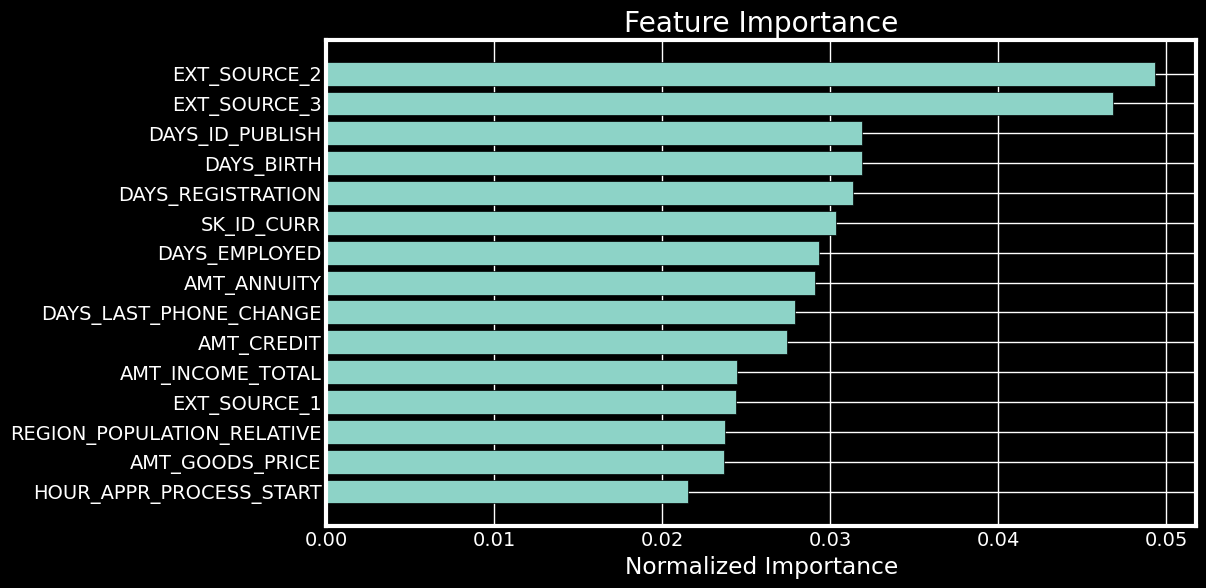

In [77]:
feature_importance_sorted = plot_feature_importance(feature_importances)

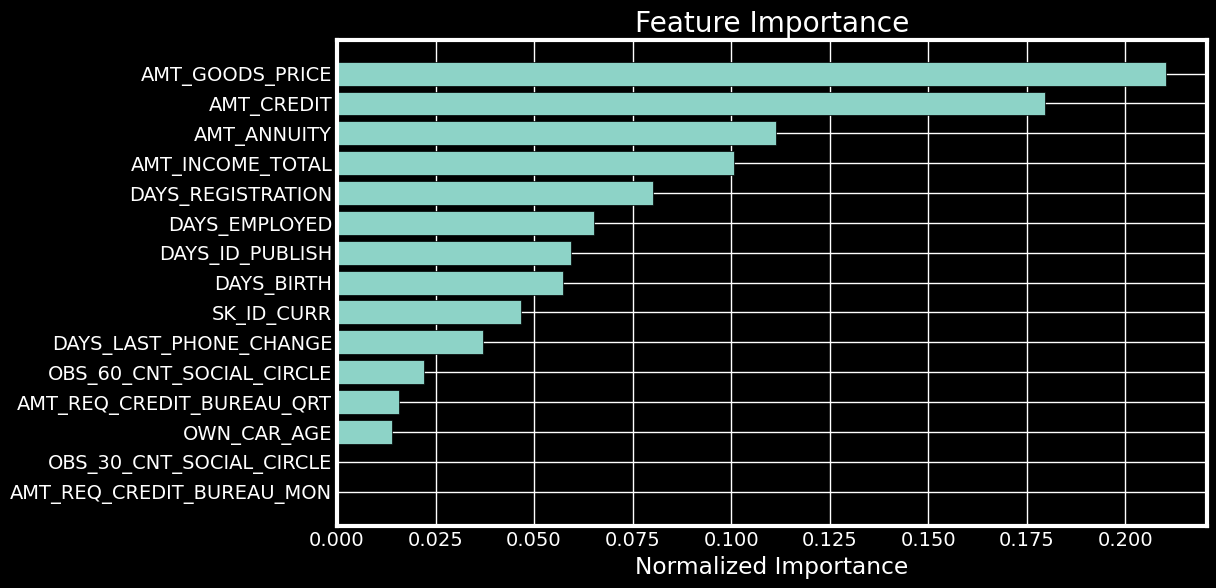

In [78]:
feature_importance_sorted = plot_feature_importance(feature_importances_s)

예상대로 가장 중요한 feature는 `EXT_SOURCE`와 `DAYS_BIRTH`입니다.\
위의 그래프를 보면 모델에 높은 importance를 지닌 feature는 소수에 불과한 것을 알 수 있습니다.\
이는 성능 저하 없이 많은 feature를 삭제할 수 있음을 시사합니다.\
(성능이 향상 될 수도 있습니다.)\
feature importance는 모델을 해석하거나 차원 축소를 하는 가장 정교한 방법은 아니지만 예측을 할 때 모델이 고려하는 요소를 이해할 수 있게 해줍니다.

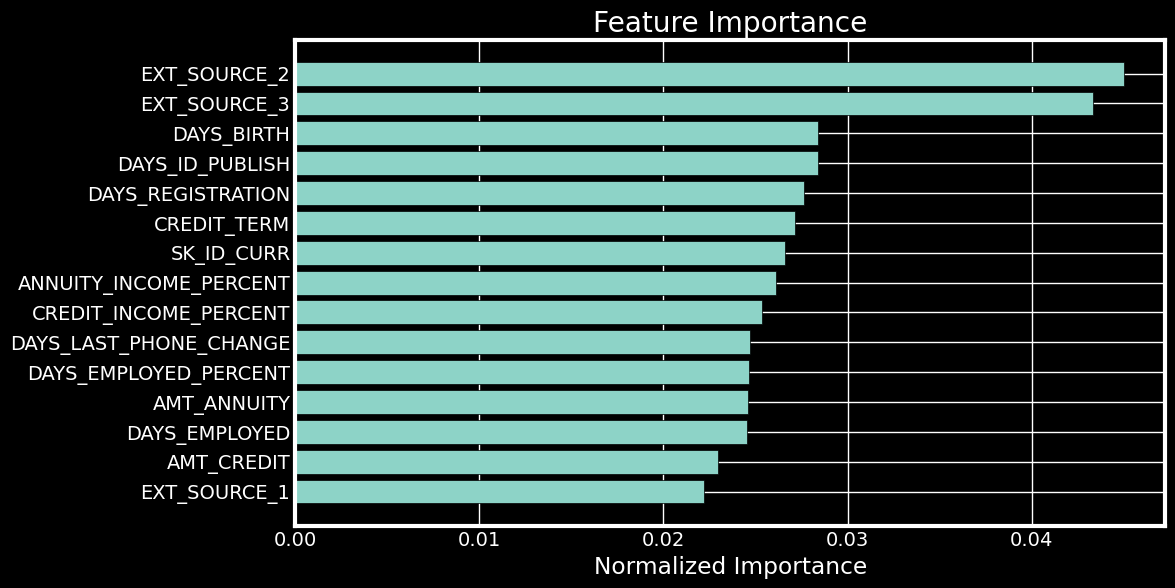

In [79]:
feature_importance_domain_sorted = plot_feature_importance(feature_importance_domain)

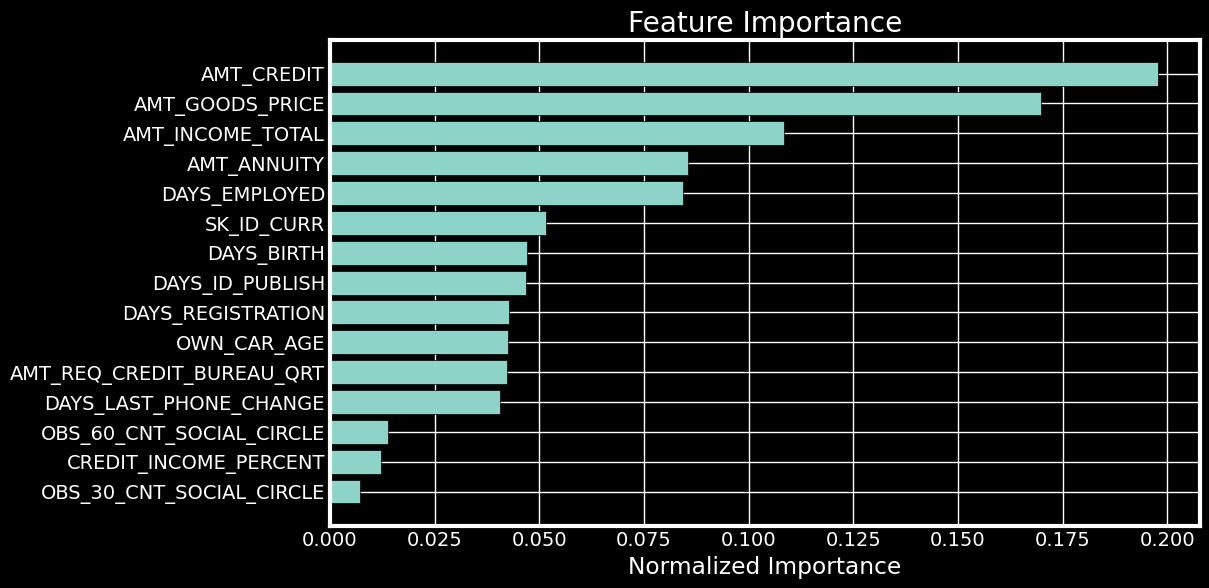

In [80]:
feature_importance_domain_sorted = plot_feature_importance(feature_importance_domain_s)

손으로 엔지니어링한 4가지 feature 모두 feature importance 상위 15위 안에 들었다는 것을 알 수 있습니다.\
이는 도메인 지식이 모델 성능에 효과가 있었다는 것을 의미합니다.

### Conclusion
이 노트북에서 Kaggle 머신 러닝 대회를 시작하는 방법을 보았습니다.\
먼저 데이터, 여러가지 작업, 제출물을 판단하는 기준을 확실히 이해했습니다.\
그런 다음 모델링에 도움이 될 수 있는 관계, 추세 또는 이상치를 식별하기 위해 간단한 EDA를 수행했습니다.\
그 과정에서 범주형 변수 인코딩, 결측값 대치, 범주형 변수 인코딩 같은 필요한 전처리 단계를 수행했습니다.\
그런 다음 기존 데이터에서 새로운 feature를 구성하여 그렇게 하는 것이 모델에 도움이 될 수 있는지를 확인했습니다.

그리고 데이터 탐색, 데이터 준비 및 feature engineering을 완료한 후, 간단한 모델을 구현했습니다.\
그런 다음 첫 번째 점수를 뛰어 넘기 위해 약간 더 복잡한 두 번째 모델을 만들었습니다.\
Engineering을 한 변수를 추가했을 때의 효과를 알아보기 위한 실험도 진행했습니다.

여기서는 머신 러닝의 프로젝트의 일반적인 개요를 따랐습니다.
1. 문제와 데이터 이해
2. 데이터 정리 및 포매팅(정보구성)(대부분 수행되어 있었음)
3. EDA
4. 기본 모델
5. 조금 더 개선한 모델
6. 모델 해석

Kaggle은 단일 metric에서 최고의 성능을 달성하는 데만 관심이 있고 해석에는 관심이 없다는 점에서 일반적인 데이터 과학 문제와 약간 다릅니다.\
그러나 모델이 결정을 내리는 방식을 이해하려고 시도함으로써 모델을 개선하고나 오류를 수정하기 위해 error를 조사할 수 있습니다.

이 노트북을 통해 이 머신러닝 대회에 참가할 수 있기를 바랍니다.\
이제 커뮤니티의 도움을 받아 스스로 나가서 큰 문제를 해결할 준비가 되었기를 바랍니다.